# Compute 3D wind work on MKE and EKE reservoirs using spatial & temporal filter

This notebook computes all diagnostics necessary for making Figure 5 in Loose et al. 2022 (JPO).
* filtered interface height
* wind work on MKE reservoir
* wind work on EKE reservoir

where all three diagnostics above are computed as function of **(layer, y, x)** for (1) a spatial filter and (2) a temporal (500-day) filter. The terms derived with (1) are averaged over 500 days.

In [1]:
filter_fac = 32  # filters from 1/32 degree to 1 degree

In [2]:
import numpy as np
import xarray as xr

import cupy as cp
from dask.diagnostics import ProgressBar
import dask

In [3]:
gpu = True

## Neverworld2 data

In [4]:
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
run = 'nw2_0.03125deg_N15_baseline_hmix20'
chunks = {'time': 1, 'zl':1}

st = xr.open_dataset('%s/%s/static.nc' % (path,run), decode_times=False)
av = xr.open_mfdataset('%s/%s/averages_*.nc' % (path, run), decode_times=False, chunks=chunks, combine='by_coords')

In [5]:
from xgcm import Grid

Nx = np.size(st.xh)
Ny = np.size(st.yh)

# symmetric
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'},
            'Z': {'center': 'zl', 'outer': 'zi'} }

grid = Grid(st, coords=coords, periodic=['X'])

st['dxT'] = grid.interp(st.dxCu,'X')
st['dyT'] = grid.interp(st.dyCv,'Y', boundary='fill')

metrics = {('X',):['dxCu','dxCv','dxT'],
           ('Y',):['dyCu','dyCv','dyT'],
           ('X', 'Y'): ['area_t', 'area_u', 'area_v']
          }
grid = Grid(st, coords=coords, periodic=['X'], metrics=metrics)

In [6]:
etaB = - st.depth_ocean
h_rev = av['h'].isel(zl=slice(None,None,-1))
eta = grid.cumsum(h_rev,'Z',boundary='fill')
eta = eta.isel(zi=slice(None,None,-1))
eta = eta + etaB
eta = eta.chunk({'zi':16})
eta = xr.where(st.wet,eta,np.nan)
av['eta'] = eta.transpose('time', 'zi', 'yh', 'xh') # reorder coordinates
av['eta'].attrs['long_name'] = 'Interface height'

### Pick 500 days (i.e., 100 time slices) of data
Consistent with time interval considered in the remainder of this work

In [7]:
av = av.isel(time=slice(-100, None))
av.time

<xarray.DataArray 'time' (time: 100)>
array([2402.5, 2407.5, 2412.5, 2417.5, 2422.5, 2427.5, 2432.5, 2437.5, 2442.5,
       2447.5, 2452.5, 2457.5, 2462.5, 2467.5, 2472.5, 2477.5, 2482.5, 2487.5,
       2492.5, 2497.5, 2502.5, 2507.5, 2512.5, 2517.5, 2522.5, 2527.5, 2532.5,
       2537.5, 2542.5, 2547.5, 2552.5, 2557.5, 2562.5, 2567.5, 2572.5, 2577.5,
       2582.5, 2587.5, 2592.5, 2597.5, 2602.5, 2607.5, 2612.5, 2617.5, 2622.5,
       2627.5, 2632.5, 2637.5, 2642.5, 2647.5, 2652.5, 2657.5, 2662.5, 2667.5,
       2672.5, 2677.5, 2682.5, 2687.5, 2692.5, 2697.5, 2702.5, 2707.5, 2712.5,
       2717.5, 2722.5, 2727.5, 2732.5, 2737.5, 2742.5, 2747.5, 2752.5, 2757.5,
       2762.5, 2767.5, 2772.5, 2777.5, 2782.5, 2787.5, 2792.5, 2797.5, 2802.5,
       2807.5, 2812.5, 2817.5, 2822.5, 2827.5, 2832.5, 2837.5, 2842.5, 2847.5,
       2852.5, 2857.5, 2862.5, 2867.5, 2872.5, 2877.5, 2882.5, 2887.5, 2892.5,
       2897.5])
Coordinates:
  * time     (time) float64 2.402e+03 2.408e+03 ... 2.892e+03 2.898e+03

## Spatial filter diagnostics

In [8]:
import gcm_filters
filter_shape = gcm_filters.FilterShape.GAUSSIAN
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

### Transform symmetric data to non-symmetric data

In [9]:
av_orig = av.copy()  # keep copy of original data
av = av.astype(np.float64)  # to avoid numerical instability
av = av.isel(xq = slice(1,None), yq=slice(1,None))

### New datasets for filtered fields

In [10]:
# new xarray dataset for filtered fields
av_f_tmp = xr.Dataset() 
av_f = xr.Dataset()

for dim in av.dims:
    av_f_tmp[dim] = av[dim]  # temporary dataset with non-symmetric dimensions
    
for dim in av_orig.dims:
    av_f[dim] = av_orig[dim]  # dataset with symmetric dimensions

#### T-fields

In [11]:
wet_mask = st.wet
area = st.area_t
if gpu:
    wet_mask = wet_mask.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
    
    area = area.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [12]:
filter_t = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )
filter_t

Filter(filter_scale=32.0, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

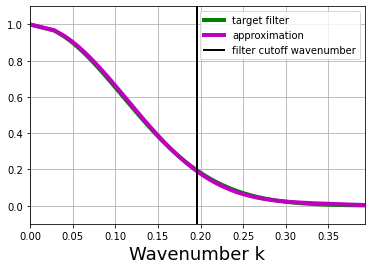

In [13]:
filter_t.plot_shape()

In [14]:
namelist = ['KE_stress', 'eta', 'h']

for name in namelist:
    field = av[name]
    if gpu:
        field.data = field.data.map_blocks(cp.asarray)        
    field_filtered = filter_t.apply(field, dims=['yh', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f[name] = field_filtered.where(st.wet)           

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

#### U-fields

In [15]:
wet_mask = st.wet_u.isel(xq=slice(1,None))
area = st.area_u.isel(xq=slice(1,None))
if gpu:
    wet_mask = wet_mask.chunk({'yh': Ny,'xq': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)

    area = area.chunk({'yh': Ny,'xq': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [16]:
filter_u = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )  
filter_u

Filter(filter_scale=32.0, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [17]:
namelist = ['u', 'du_dt_str_visc_rem', 'uh', 'h_du_dt_str']

for name in namelist:
    field = av[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_u.apply(field, dims=['yh', 'xq'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f_tmp[name] = field_filtered 
    av_f_tmp[name] = av_f_tmp[name].transpose('time', 'zl', 'yh', 'xq') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the western edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        av_f[name] = av_f_tmp[name]
    av_f[name] = xr.where(av_f.xq==av_f.xq[0], av_f[name].roll(xq=1,roll_coords=False), av_f[name])
    av_f[name] = av_f[name].where(st.wet_u)
    av_f[name] = av_f[name].transpose('time', 'zl', 'yh', 'xq')

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,


#### V-fields

In [18]:
wet_mask = st.wet_v.isel(yq=slice(1,None))
area = st.area_v.isel(yq=slice(1,None))
if gpu:
    wet_mask = wet_mask.chunk({'yq': Ny,'xh': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
    
    area = area.chunk({'yq': Ny,'xh': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [19]:
filter_v = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )    
filter_v

Filter(filter_scale=32.0, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [20]:
namelist = ['v', 'dv_dt_str_visc_rem', 'vh', 'h_dv_dt_str']

for name in namelist:
    field = av[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_v.apply(field, dims=['yq', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f_tmp[name] = field_filtered  
    av_f_tmp[name] = av_f_tmp[name].transpose('time', 'zl', 'yq', 'xh') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the southern edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        av_f[name] = av_f_tmp[name]

    # set yq = 0 to nan's (all land):        
    av_f[name] = xr.where(av_f.yq==av_f.yq[0], np.nan, av_f[name])
    av_f[name] = av_f[name].where(st.wet_v)
    av_f[name] = av_f[name].transpose('time', 'zl', 'yq', 'xh')

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,


### Compute wind work diagnostics

In [21]:
ds_spatial = xr.Dataset()

In [22]:
# wind work on MKE and EKE reservoirs 

# non-TWA (compare compute_2d_Lorenz_cycle.ipynb)
ds_spatial['MKE_wind_stress'] = av_f['h'] * (
    grid.interp((av_f['u'] * (av_f['du_dt_str_visc_rem'])).fillna(value=0), 'X', metric_weighted=['X','Y']) 
    + grid.interp(av_f['v'] * (av_f['dv_dt_str_visc_rem']).fillna(value=0), 'Y', metric_weighted=['X','Y']) 
)
    
ds_spatial['EKE_wind_stress'] = av_f['KE_stress'] - ds_spatial['MKE_wind_stress']

# TWA (compare compute_2d_Bleck_cycle.ipynb)
ds_spatial['MKE_TWA_wind_stress'] = (
    grid.interp((av_f['uh'] * st['dxCu'] * av_f['h_du_dt_str']).fillna(value=0), 'X', metric_weighted=['X','Y'])
    + grid.interp((av_f['vh'] * st['dyCv'] * av_f['h_dv_dt_str']).fillna(value=0), 'Y', metric_weighted=['X','Y'])
) / av_f['h'] / st['area_t']

ds_spatial['EKE_TWA_wind_stress'] = av_f['KE_stress'] - ds_spatial['MKE_TWA_wind_stress']

In [23]:
ds_spatial['eta'] = av_f['eta']

In [24]:
# compute 500 day mean
dst_spatial = ds_spatial.mean(dim='time')

## Temporal filter diagnostics

In [25]:
namelist = ['h', 'KE_stress', 'eta', 'u', 'du_dt_str_visc_rem', 'uh', 'h_du_dt_str', 'v', 'dv_dt_str_visc_rem', 'vh', 'h_dv_dt_str']

In [26]:
av_t = av_orig.mean(dim='time')

In [27]:
dst_temporal = xr.Dataset()

In [28]:
# wind work on MKE and EKE reservoirs 

# non-TWA (compare compute_2d_Lorenz_cycle.ipynb)
dst_temporal['MKE_wind_stress'] = av_t['h'] * (
    grid.interp((av_t['u'] * (av_t['du_dt_str_visc_rem'])).fillna(value=0), 'X', metric_weighted=['X','Y']) 
    + grid.interp(av_t['v'] * (av_t['dv_dt_str_visc_rem']).fillna(value=0), 'Y', metric_weighted=['X','Y']) 
)
    
dst_temporal['EKE_wind_stress'] = av_t['KE_stress'] - dst_temporal['MKE_wind_stress']

# TWA (compare compute_2d_Bleck_cycle.ipynb)
dst_temporal['MKE_TWA_wind_stress'] = (
    grid.interp((av_t['uh'] * st['dxCu'] * av_t['h_du_dt_str']).fillna(value=0), 'X', metric_weighted=['X','Y'])
    + grid.interp((av_t['vh'] * st['dyCv'] * av_t['h_dv_dt_str']).fillna(value=0), 'Y', metric_weighted=['X','Y'])
) / av_t['h'] / st['area_t']

dst_temporal['EKE_TWA_wind_stress'] = av_t['KE_stress'] - dst_temporal['MKE_TWA_wind_stress']

In [29]:
dst_temporal['eta'] = av_t['eta']

## Write to file

In [30]:
workpath = '/glade/work/noraloose/'

In [31]:
filename_s = '%s/%s/wind_work_diags_spatial_filterfac%i_500days.nc' %(workpath, run, filter_fac)
filename_s

'/glade/work/noraloose//nw2_0.03125deg_N15_baseline_hmix20/wind_work_diags_spatial_filterfac32_500days.nc'

In [32]:
dst_spatial

<xarray.Dataset>
Dimensions:              (yh: 4480, zl: 15, xh: 1920, zi: 16)
Coordinates:
  * yh                   (yh) float64 -69.98 -69.95 -69.92 ... 69.92 69.95 69.98
  * zl                   (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03
  * xh                   (xh) float64 0.01562 0.04688 0.07812 ... 59.95 59.98
  * zi                   (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03
Data variables:
    MKE_wind_stress      (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    EKE_wind_stress      (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    MKE_TWA_wind_stress  (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    EKE_TWA_wind_stress  (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    eta                  (zi, yh, xh) float64 dask.array<chunksize=(16, 4480, 1920), meta=np.ndarray>

In [33]:
with ProgressBar():
    dst_spatial.to_netcdf(filename_s)

[####                                    ] | 11% Completed | 31min  0.3s

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  3hr 52min  3.7s


In [34]:
filename_t = '%s/%s/wind_work_diags_temporal_500days.nc' %(workpath, run)
filename_t

'/glade/work/noraloose//nw2_0.03125deg_N15_baseline_hmix20/wind_work_diags_temporal_500days.nc'

In [35]:
dst_temporal

<xarray.Dataset>
Dimensions:              (yh: 4480, zl: 15, xh: 1920, zi: 16)
Coordinates:
  * yh                   (yh) float64 -69.98 -69.95 -69.92 ... 69.92 69.95 69.98
  * zl                   (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03
  * xh                   (xh) float64 0.01562 0.04688 0.07812 ... 59.95 59.98
  * zi                   (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03
Data variables:
    MKE_wind_stress      (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    EKE_wind_stress      (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    MKE_TWA_wind_stress  (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    EKE_TWA_wind_stress  (zl, yh, xh) float64 dask.array<chunksize=(1, 4480, 1920), meta=np.ndarray>
    eta                  (zi, yh, xh) float32 dask.array<chunksize=(16, 4480, 1920), meta=np.ndarray>

In [36]:
with ProgressBar():
    dst_temporal.to_netcdf(filename_t)

[##########                              ] | 25% Completed | 12min 57.5s

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1hr 19min 47.7s
